# FIT5202 Assignment 2A : Building models to predict future eCommerce sales

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Data Ethics, Privacy, and Security](#part-3)

Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Usage of Spark SQL is discouraged, and your can only use pandas to format results. For plotting, different visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size not exceed 20MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is also acceptable.)

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
#define worker
master = "local[4]"
#define app name
app_name = "Assignment2"
#setup worker and app name for spark conf
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# set the session time to australia time
spark_conf.set("spark.sql.session.timeZone", "Australia/Melbourne")
#set max partition size not exceed 20 mb
spark_conf.set("spark.sql.files.maxPartitionBytes", "20m")
spark_conf.set("spark.driver.memory", "8g")

#initialize spark session and spark context
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")


1.1.2 Write code to define the schemas for category, customer, product, clickstream and transaction datasets, following the data types suggested in the metadata file.

In [ ]:
from pyspark.sql.types import *

# create schema for category , customer,product, clickstream, transaction
# customer schema
customer_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("customer_id", IntegerType(), True),
        StructField("first_name", StringType(), True),
        StructField("last_name", StringType(), True),
        StructField("username", StringType(), True),
        StructField("email", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("birthdate", DateType(), True),
        StructField("device_type", StringType(), True),
        StructField("device_id", StringType(), True),
        StructField("device_version", StringType(), True),
        StructField("home_location_lat", FloatType(), True),
        StructField("home_location_long", FloatType(), True),
        StructField("home_location", StringType(), True),
        StructField("home_country", StringType(), True),
        StructField("first_join_date", DateType(), True),
    ]
)

# category schema
category_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("category_id", IntegerType(), True),
        StructField("cat_level1", StringType(), True),
        StructField("cat_level2", StringType(), True),
        StructField("cat_level3", StringType(), True),
    ]
)

# click_stream schema
click_stream_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("session_id", StringType(), True),
        StructField("event_name", StringType(), True),
        StructField("event_time", TimestampType(), True),
        StructField("event_id", StringType(), True),
        StructField("traffic_source", StringType(), True),
        StructField("event_metadata", StringType(), True),
    ]
)
# product schema
product_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("id", IntegerType(), True),
        StructField("gender", StringType(), True),
        StructField("baseColour", StringType(), True),
        StructField("season", StringType(), True),
        StructField("year", IntegerType(), True),
        StructField("usage", StringType(), True),
        StructField("productDisplayName", StringType(), True),
        StructField("category_id", IntegerType(), True),
    ]
)



# transaction schema
transaction_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("customer_id", IntegerType(), True),
        StructField("booking_id", StringType(), True),
        StructField("session_id", StringType(), True),
        StructField("product_metadata", StringType(), True),
        StructField("payment_method", StringType(), True),
        StructField("payment_status", StringType(), True),
        StructField("promo_amount", DoubleType(), True),
        StructField("promo_code", StringType(), True),
        StructField("shipment_fee", DoubleType(), True),
        StructField("shipment_date_limit", DateType(), True),
        StructField("shipment_location_lat", FloatType(), True),
        StructField("shipment_location_long", FloatType(), True),
        StructField("total_amount", DoubleType(), True),
    ]
)
#product metadata schema from transaction_schema
product_metadata_schema = StructType([
        StructField("booking_id", StringType(), True),
        StructField("product_id", IntegerType(), True),
        StructField("quantity", IntegerType(), True),
        StructField("item_price", FloatType(), True)

])

# customer schema
customer_session_schema = StructType(
    [
        StructField("#", IntegerType(), True),
        StructField("session_id", StringType(), True),
        StructField("customer_id", IntegerType(), True),
    ]
)

1.1.3 Using predefined schema, write code to load the csv files into separate dataframes. Print the schemas of all dataframes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data into DataFrames with specified schemas
from pyspark.sql.functions import col, from_json, when,concat,explode,regexp_replace
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from pyspark.sql.functions import from_json
#load data from customer csv to customer df
customer_df = (
    spark.read.format("csv")
    .option("header", "true")
    .schema(customer_schema)
    .load("/content/drive/MyDrive/customer.csv")
    .drop("#")
)
#load data from category csv to category df
category_df = (
    spark.read.format("csv")
    .option("header", "true")
    .schema(category_schema)
    .load("/content/drive/MyDrive/category.csv")
    .drop("#")
)
#load data from click stream csv to click stream df
click_stream_df = (
    spark.read.format("csv")
    .option("header", "true")
    .schema(click_stream_schema)
    .load("/content/drive/MyDrive/click_stream.csv")
    .drop("#")
)
#load data from product csv to product df
product_df = (
    spark.read.format("csv")
    .option("header", "true")
    .schema(product_schema)
    .load("/content/drive/MyDrive/product.csv")
    .drop("#")
)
#load data from transaction csv to transaction df
transaction_df= (
    spark.read.format("csv")
    .option("header", "true")
    .schema(transaction_schema)
    .load("/content/drive/MyDrive/new_transactions.csv")
    .drop("#")
)

#load data from customer_session csv to customer_session df
customer_session_df = (
    spark.read.format("csv")
    .option("header", "true")
    .schema(customer_session_schema)
    .load("/content/drive/MyDrive/customer_session.csv")
    .drop("#")
)


#parse data from column product_metadata and load into product_metadata df
parsed_df = transaction_df.withColumn("parsed_product_metadata",
    from_json(col("product_metadata"), ArrayType(product_metadata_schema))
)

exploded_df = parsed_df.select(
    col("booking_id"),
    explode(col("parsed_product_metadata")).alias("product_metadata")
)

exploded_df = exploded_df.withColumn(
    "product_metadata.product_id",
    regexp_replace(col("product_metadata.product_id"), r"[\[\]]", "")
)

exploded_df = exploded_df.withColumn(
    "product_metadata.quantity",
    regexp_replace(col("product_metadata.quantity"), r"[\[\]]", "")
)

exploded_df = exploded_df.withColumn(
    "product_metadata.item_price",
    regexp_replace(col("product_metadata.item_price"), r"[\[\]]", "")
)


product_metadata_df = exploded_df.select(
    col("booking_id"),
    col("product_metadata.product_id").alias("product_id"),
    col("product_metadata.quantity").alias("quantity"),
    col("product_metadata.item_price").alias("item_price")
)


# print the schema for each dataframe
customer_df.printSchema()

category_df.printSchema()

click_stream_df.printSchema()

product_df.printSchema()

transaction_df.printSchema()

customer_session_df.printSchema()

product_metadata_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: float (nullable = true)
 |-- home_location_long: float (nullable = true)
 |-- home_location: string (nullable = true)
 |-- home_country: string (nullable = true)
 |-- first_join_date: date (nullable = true)

root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)

root
 |-- session_id: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_id: string (nullable = true)
 |

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the clickstream dataset, there are 9 types of events:  
VIEW_PROMO, SCROLL, ADD_PROMO, VIEW_ITEM, CLICK, PURCHASE, ADD_TO_CART, HOMEPAGE, SEARCH  
We categorize them into 3 different categories:  
Category 1(high value actions - highly likely to purchase): ADD_PROMO, ADD_TO_CART  
Category 2(medium value actions - likely to purchase): VIEW_PROMO, VIEW_ITEM, SEARCH  
Category 3(low value actions - just browsing):  SCROLL, HOMEPAGE, CLICK  
Perform the following tasks base on the clickstream dataframe and create a new dataframe.  

1.2.1 For each unique session_id, count the number of actions in each category and create 3 columns(num_cat_highvalue, num_cat_midvalue, num_cat_lowvalue).

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Extract year and month from the event timestamp
category_click_stream_df = click_stream_df \
    .withColumn("event_year", F.year(F.col("event_time"))) \

# Categorize each event
categorization_exp = (
    F.when(F.col("event_name").isin(["ADD_PROMO", "ADD_TO_CART"]), "Category 1")
    .when(F.col("event_name").isin(["VIEW_PROMO", "VIEW_ITEM", "SEARCH"]), "Category 2")
    .when(F.col("event_name").isin(["SCROLL", "HOMEPAGE", "CLICK"]), "Category 3")
    .otherwise("Unknown")
)

# Add new column category on each click stream data
category_click_stream_df = category_click_stream_df.withColumn("category", categorization_exp)

# Group data by session_id, event_year, and event_month and count each data
category_click_stream_df = (
    category_click_stream_df.groupBy("session_id", "event_year")
    .pivot("category", ["Category 1", "Category 2", "Category 3"])
    .agg(F.count("*").alias("count"))
    .fillna(0)
)

# Rename the columns
category_click_stream_df = category_click_stream_df.withColumnRenamed("Category 1", "num_cat_highvalue") \
    .withColumnRenamed("Category 2", "num_cat_midvalue") \
    .withColumnRenamed("Category 3", "num_cat_lowvalue")

# Print the schema
category_click_stream_df.printSchema()

# Display the result
category_click_stream_df.show(10)


root
 |-- session_id: string (nullable = true)
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)

+--------------------+----------+-----------------+----------------+----------------+
|          session_id|event_year|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|
+--------------------+----------+-----------------+----------------+----------------+
|2af607a0-1506-4c4...|      2020|                2|               2|               7|
|0d6324c2-5aeb-46e...|      2020|                1|               2|              12|
|69aa38e8-5c2f-446...|      2020|                4|               4|               6|
|2cbec94f-f44f-4bf...|      2019|                2|               1|               3|
|1760177a-a110-47c...|      2018|                1|               1|               2|
|76d77b62-618d-405...|      2020|                1|               0|              

1.2.2. Create 2 columns with percentage ratio of high value action and low value actions. (i.e. high value ratio = (count of high value actions)/(total actions) * 100%)

In [ ]:
from pyspark.sql.functions import col, format_number


# add new column to store total all actions
category_click_stream_df = category_click_stream_df.withColumn(
    "total_actions",
    col("num_cat_highvalue") + col("num_cat_midvalue") + col("num_cat_lowvalue"),
)

# add new column to store percentage ratio of all actions
# count of actions/total_actions *100
category_click_stream_df = category_click_stream_df.withColumn(
    "high_value_ratio",
    (col("num_cat_highvalue") / col("total_actions")) * 100,
).withColumn(
    "medium_value_ratio",
    (col("num_cat_midvalue") / col("total_actions")) * 100,
).withColumn(
    "low_value_ratio",
    (col("num_cat_lowvalue") / col("total_actions")) * 100,
)

#drop unused column
category_click_stream_df=category_click_stream_df.drop('total_actions')

#print schema
category_click_stream_df.printSchema()

#display the result
category_click_stream_df.show(10)

row_count = category_click_stream_df.count()

print(f"Total number of rows: {row_count}")

root
 |-- session_id: string (nullable = true)
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)

+--------------------+----------+-----------------+----------------+----------------+------------------+------------------+------------------+
|          session_id|event_year|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|  high_value_ratio|medium_value_ratio|   low_value_ratio|
+--------------------+----------+-----------------+----------------+----------------+------------------+------------------+------------------+
|2af607a0-1506-4c4...|      2020|                2|               2|               7|18.181818181818183|18.181818181818183| 63.63636363636363|
|0d6324c2-5aeb-46e...|      2020|                1|  

1.2.3 Create a new column “is_promotion” with value of 1 or 0 and add to feature_df. If there are “ADD_PROMO” actions in a session, set it to 1, otherwise 0.

In [ ]:
from pyspark.sql.functions import when, col

# Collect session id which has add promo event
add_promo_exists = (
    click_stream_df.filter(col("event_name") == "ADD_PROMO")
    .select("session_id")
    .distinct()
)

# add new column "is_promotion" if there is an "add_promo" event on the session id
feature_df = category_click_stream_df.withColumn(
    "is_promotion",
    when(
        col("session_id").isin([row.session_id for row in add_promo_exists.collect()]),
        1,
    ).otherwise(0),
)

# Print the schema
feature_df.printSchema()

# Display the result
feature_df.show(10)


row_count = feature_df.count()

print(f"Total number of rows: {row_count}")

root
 |-- session_id: string (nullable = true)
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)

+--------------------+----------+-----------------+----------------+----------------+------------------+------------------+------------------+------------+
|          session_id|event_year|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|  high_value_ratio|medium_value_ratio|   low_value_ratio|is_promotion|
+--------------------+----------+-----------------+----------------+----------------+------------------+------------------+------------------+------------+
|2af607a0-1506-4c4...|      2020|                2|               2|               7|18.181818181818183|18.1818

1.2.4 For each unique session_id, base on event_time, extract the season. (note: The dataset is from Indonesia, Spring: Mar-May, Summer: Jun-Aug, Autumn: Sep-Nov, Winter: Dec-Feb)

In [ ]:
from pyspark.sql.functions import when, col, hour, max, broadcast, date_format

# Get max event time for each session
max_month = click_stream_df.groupBy("session_id").agg(max(col("event_time")).alias("max_event_time"))

# Extract month of max event time and their session id
season_df = max_month.select(
    "session_id", date_format("max_event_time", "MM").alias("event_month")
).distinct()

# Define season rules for each event month
season_df = season_df.withColumn(
    "season",
    when(col("event_month").isin(['03', '04', '05']), "Spring")
    .when(col("event_month").isin(['06', '07', '08']), "Summer")
    .when(col("event_month").isin(['09', '10', '11']), "Autumn")
    .otherwise("Winter"),
)

# Rename column name before join
season_df = season_df.withColumnRenamed("session_id", "session_id2")

click_stream_df = click_stream_df.withColumn(
    "morning", when(hour("event_time").between(6, 11), 1).otherwise(0)
).withColumn(
    "afternoon", when(hour("event_time").between(12, 17), 1).otherwise(0)
).withColumn(
    "evening", when(hour("event_time").between(18, 23), 1).otherwise(0)
).withColumn(
    "night", when(hour("event_time").between(0, 5), 1).otherwise(0)
)

# Aggregate counts for each time period per session
time_period_counts = click_stream_df.groupBy("session_id").agg(
    F.sum("morning").alias("morning_count"),
    F.sum("afternoon").alias("afternoon_count"),
    F.sum("evening").alias("evening_count"),
    F.sum("night").alias("night_count")
)


# Join time period counts back to feature_df
feature_df = feature_df.join(time_period_counts, "session_id", "left")

# Join season information back to feature_df
feature_df = feature_df.join(
    broadcast(season_df.select("session_id2", "season")),
    on=(feature_df["session_id"] == season_df["session_id2"]),
    how="left"
)

# Drop unused column
feature_df = feature_df.drop('session_id2')

# Print schema to confirm changes
feature_df.printSchema()


row_count = feature_df.count()

print(f"Total number of rows: {row_count}")


root
 |-- session_id: string (nullable = true)
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- season: string (nullable = true)

Total number of rows: 922686


1.2.5 Join tables to find customer information and add columns to feature_df: gender, age, device type, home_location, first join year. (note: For some column, you need to perform transformation. For age, keep integer only.)

In [ ]:
from pyspark.sql.functions import year, current_date


row_count = feature_df.count()

print(f"Total number of rows: {row_count}")

# Select columns from customer_df and add 2 new columns: "first_join_year" and "age"
customer_temp_df = customer_df.select(
    "customer_id",
    "gender",
    "device_type",
    "birthdate",
    "home_location",
    "first_join_date",
).withColumn("first_join_year", year("first_join_date")).withColumn("age", year(current_date()) - year("birthdate"))

# Rename column before join
customer_temp_df = customer_temp_df.withColumnRenamed("customer_id", "customer_id3")

# Rename columns before join
customer_session_df = customer_session_df.withColumnRenamed(
    "session_id", "session_id3"
).withColumnRenamed("customer_id", "customer_id2")

# Join customer_temp_df and customer_session_df
feature_temp_df = customer_temp_df.join(
    customer_session_df,
    (customer_session_df.customer_id2 == customer_temp_df.customer_id3),
    "inner"
)

# Join feature_df and feature_temp_df
feature_df = feature_df.join(
    feature_temp_df,
    (feature_temp_df.session_id3 == feature_df.session_id),
    "inner"
)


# Drop unused columns
feature_df = (
    feature_df.drop("session_id2")
    .drop("first_join_date")
    .drop("birthdate")
    .drop("customer_id2")
    .drop('session_id')
)

# Print schema
feature_df.printSchema()

# Display the result
feature_df.show(10)


row_count = feature_df.count()

print(f"Total number of rows: {row_count}")

Total number of rows: 922686
root
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- season: string (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- first_join_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)

+----------+-----------------+----------------+----------------+------------------+-

1.2.6 Join tables to find out if the customer made purchase or not, and add to feature_df as 1 or 0. We will use this column as training label later.

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F

# Select relevant columns from transaction_df for successful and failed transactions
transaction_temp_df = transaction_df.select("customer_id", "session_id", "payment_status").filter(transaction_df['payment_status'].isin('Success', 'Fail'))

# Left outer join between feature_df and transaction_temp_df using session_id and customer_id
feature_df = feature_df.join(
    transaction_temp_df,
    (feature_df.session_id3 == transaction_temp_df.session_id) &
    (feature_df.customer_id3 == transaction_temp_df.customer_id),
    how="leftouter"
)

# Create a new column that captures the purchase status:
# 1 for successful purchase, -1 for unsuccessful, and 0 for no purchase
feature_df = feature_df.withColumn(
    "made_purchase",
    when(col("session_id3").isNotNull() & (col("payment_status") == 'Success'), 1)
    .otherwise(0)
)

# Print schema and show a sample of the resulting DataFrame
feature_df.printSchema()
feature_df.show(10)

# Count the number of rows in the resulting DataFrame
row_count = feature_df.count()

# Print the row count
print(f"Total number of rows: {row_count}")



root
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- season: string (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- first_join_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- payment_status: string 

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b)For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count.**

In [ ]:
from pyspark.sql.functions import expr, col
# Define numeric data type
numeric_data_types = ["double", "int", "bigint", "float"]

# Get data types
column_data_types = feature_df.dtypes

# Filter numeric columns
numeric_columns = [
    column
    for column, data_type in column_data_types
    if data_type.lower() in numeric_data_types
]

# Select count,stddev,min,max of feature_df's column
statistics_df = feature_df.select(numeric_columns).summary(
    "count", "mean", "stddev", "min", "max"
)
# Define percentiles columns
percentiles = [0.25, 0.50, 0.75]
percentile_columns = []

for col_name in numeric_columns:
    for percentile in percentiles:
        percentile_col_name = f"{col_name}_percentile_{int(percentile*100)}"
        percentile_value = feature_df.approxQuantile(
            col_name, [percentile], 0.01
        )
        percentile_columns.append(
            expr(f"'{percentile_value[0]}' AS `{percentile_col_name}`")
        )

# Merge all columns
statistics_df = statistics_df.select("*", *percentile_columns)

# Display the result
statistics_df.show()


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-------------------+------------------------+------------------------+------------------------+-------------------------------+-------------------------------+-------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+--------------------------------+--------------------------------+--------------------------------+-----------------------------+-----------------------------+-----------------------------+--------------------------+------

In [ ]:
from pyspark.sql.functions import col,desc
# Define string data type
string_data_types = ["string"]

# Get data types
column_data_types = feature_df.dtypes

# Filter string columns
string_columns = [
    column
    for column, data_type in column_data_types
    if data_type.lower() in string_data_types
]

# Display the top-5 values and the counts
for col_name in string_columns:
    print(f"Top 5 values and counts for column '{col_name}':")
    feature_df.groupBy(col_name).count().orderBy(desc("count")).show(5)


Top 5 values and counts for column 'season':
+------+------+
|season| count|
+------+------+
|Spring|237619|
|Winter|229132|
|Summer|223091|
|Autumn|190222|
+------+------+

Top 5 values and counts for column 'gender':
+------+------+
|gender| count|
+------+------+
|     F|560976|
|     M|319088|
+------+------+

Top 5 values and counts for column 'device_type':
+-----------+------+
|device_type| count|
+-----------+------+
|    Android|677920|
|        iOS|202144|
+-----------+------+

Top 5 values and counts for column 'home_location':
+-------------+------+
|home_location| count|
+-------------+------+
| Jakarta Raya|161854|
|   Jawa Barat|104425|
|  Jawa Tengah| 98154|
|   Jawa Timur| 83823|
|   Yogyakarta| 68589|
+-------------+------+
only showing top 5 rows

Top 5 values and counts for column 'session_id3':
+--------------------+-----+
|         session_id3|count|
+--------------------+-----+
|8505d640-bd40-45c...|    4|
|8b4c650c-f4fa-490...|    4|
|743cc8f5-2e0c-4e7...|    4|

In [ ]:
from pyspark.sql.functions import col,desc

# Define columns with boolean data type
boolean_columns = ["is_promotion", "made_purchase"]

# For each column, display values and their counts
for col_name in boolean_columns:
    print(f"Values and Count for column '{col_name}':")
    feature_df.groupBy(col_name).count().orderBy(desc("count")).show(5)


Values and Count for column 'is_promotion':
+------------+------+
|is_promotion| count|
+------------+------+
|           0|537414|
|           1|335000|
+------------+------+

Values and Count for column 'made_purchase':
+-------------+------+
|made_purchase| count|
+-------------+------+
|            1|540502|
|            0|331912|
+-------------+------+



**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots.**
- One of the plots needs to base on feature_df, you’re free to choose the other one.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots; 2: if your data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  
- Please only use the provided data for visualisation  


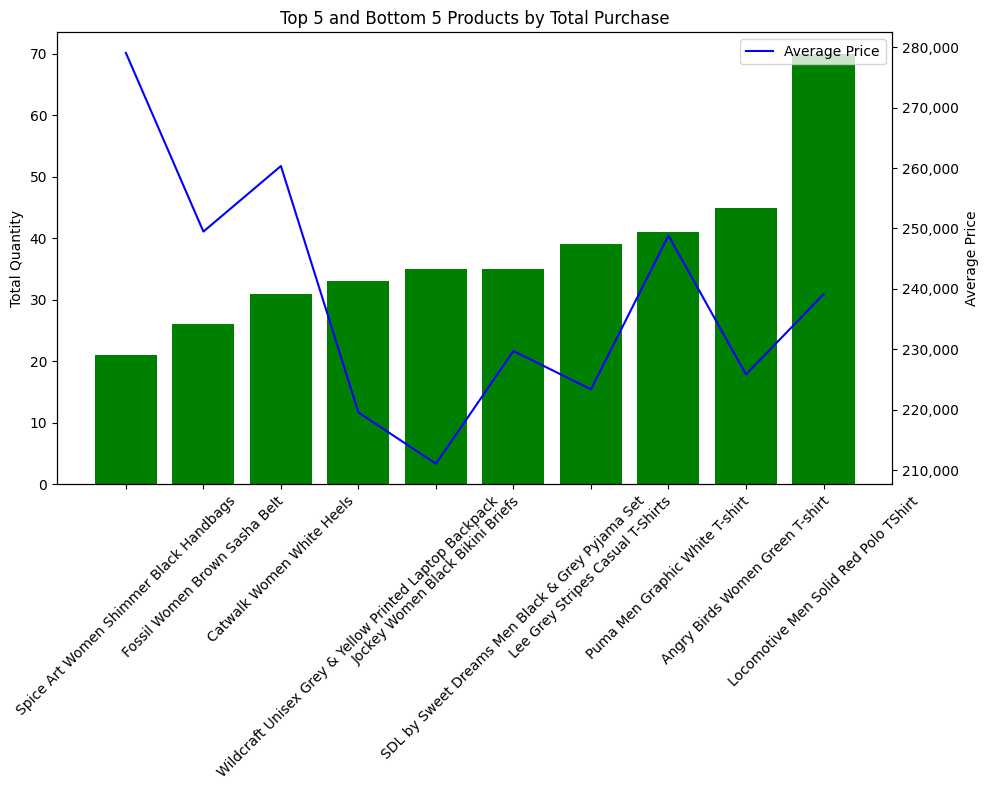

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import desc
from matplotlib.ticker import FuncFormatter

# Format number
def format_int(x, pos):
    return f'{x:,.0f}'

# Formatter for y axis
y_format = FuncFormatter(format_int)

# Count product based on number of purchase
top_products_df = product_metadata_df.groupBy("product_id") \
    .agg({"quantity": "sum", "item_price": "avg"}) \
    .withColumnRenamed("sum(quantity)", "total_quantity") \
    .withColumnRenamed("avg(item_price)", "average_price") \
    .orderBy(desc("total_quantity"))

# Select specific column to use
product_df2 = product_df.select("id", "productDisplayname")

# Join top product with product dataframe
joined_df = top_products_df.join(
    product_df2, top_products_df.product_id == product_df2.id, "left"
)

# Select the top 5 and bottom 5 products
top5 = pd.DataFrame(joined_df.head(5))
bottom5 = pd.DataFrame(joined_df.tail(5))
merged_df = pd.concat([top5, bottom5])
merged_df = merged_df.sort_values(by=1)


plt.figure(figsize=(10, 8))

# Viusalize the plot
plt.bar(merged_df[4], merged_df[1], color="g", label="Total Purchase")
plt.ylabel("Total Quantity")
plt.title("Top 5 and Bottom 5 Products by Total Purchase")
plt.xticks(rotation=45)
plt.twinx()
plt.plot(merged_df[4], merged_df[2], "b-", label="Average Price")
plt.ylabel("Average Price")
plt.gca().yaxis.set_major_formatter(y_format)

# Add legends
plt.legend(loc="upper left")
plt.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()


**Explanation:**
This chart helps a company figure out which is the best seller product and the least popular product. It will help company make  decisions like restocking popular items, improving marketing, and understanding what customers like.
From the chart, we can see that people in Indonesia really like buying fashion items the most. Most of the products are also on similar price range, it shows Indonesian customers prefer this price range.
By focusing on the products that are selling the best, a company can use its resources wisely and make more money. For products that aren't selling well, the company can try different things like giving discounts or selling them together as a bundle. Company could check this data regularly because what people want and what's popular can change.

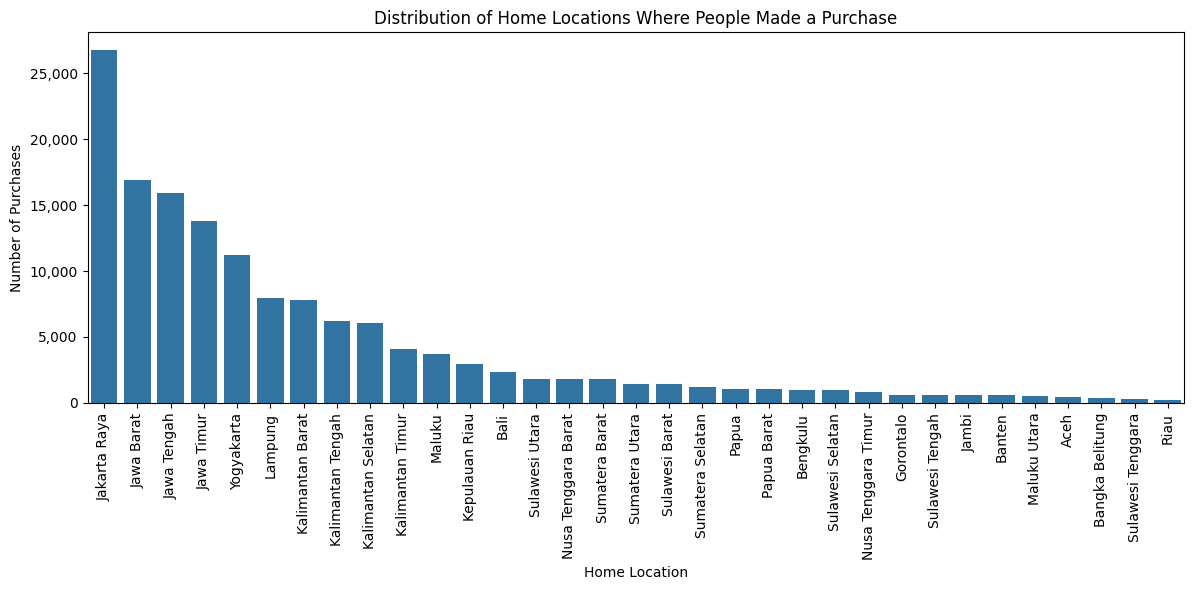

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Format integer number
def format_int(x, pos):
    return f'{x:,.0f}'

# Formatter for y axis
y_format = FuncFormatter(format_int)

# Filter successful transaction
purchase_df = feature_df.filter(feature_df['made_purchase'] == 1)

# Sample data before visualize
sampled_purchase_df = purchase_df.sample(withReplacement=False, fraction=0.2, seed=42)

# Group the home locations and count number of purchases
location_counts = sampled_purchase_df.groupBy('home_location').count().orderBy('count', ascending=False).toPandas()
location_counts.columns = ['Home Location', 'Number of Purchases']

# Create a barplot to visualize the distribution of home locations
plt.figure(figsize=(12, 6))
sns.barplot(data=location_counts, x='Home Location', y='Number of Purchases', order=location_counts['Home Location'])
plt.xticks(rotation=90)
plt.xlabel('Home Location')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Home Locations Where People Made a Purchase')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(y_format)

# Show the plot
plt.show()


**Explanation :**

The chart helps us identify which areas have the most customers making purchases, providing valuable insights for our targeted marketing efforts. For instance, we observe that places in Java Island, such as Jakarta Raya, Jawa Barat, Jawa Tengah, Jawa Timur, and Yogyakarta, have notably high purchase activity. There are many possible reasons ,such as higher incomes, increased product demand, a denser population, and a tech-savvy demographic.
With this data, we can enhance our planning by ensuring adequate product and service availability in these busy regions. On other side, for areas with lower purchase activity, it's crucial to investigate the underlying reasons. Possible explanations may include a preference for traditional in-store shopping or limited familiarity with our app. We may need to customize our marketing strategies and product offerings to better align with individual's need  in these areas.



## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you will need to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the situation we have, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Please only use the provided data for model building
- You can create/add additional feature/column based on the dataset
- Hint - things to consider include whether to create more feature columns, whether to remove some columns, using the insights from the data exploration/domain knowledge/statistical models  

In [ ]:
feature_df.printSchema()

root
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- season: string (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- first_join_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- payment_status: string 

**Features to Remove:**
1.   num_cat_highvalue
2.   num_cat_midvalue
3.   num_cat_lowvalue

Reason : I removed because they provide similar information as high_value_ratio, medium_value_ratio, and low_value_ratio.

4.   session_id
5.   customer_id

Reason : I removed because they don't contribute to our understanding of why people make purchases.
6.   season

Reason : I removed because it didn't appear to have a noticeable impact on the data when examining its distribution.
7.   device_type
Reason : I removed this feature because there is no correlation between people's device type and their decisions when they want to buy something .

**Features to Transform:**

1.   first_join_year

Action : I renamed this as "duration_join_app" because it allows us to
explore whether long-term users tend to spend more over time.

 **Features to Keep:**

1.   high_value_ratio
2.   medium_value_ratio
3.   low_value_ratio

Reason : I kept these features because they offer valuable insights into user behavior on the app. It also has high correlation with made_purchase .

4.   age
Reason : I kept these because it revealed distinct patterns of activity on the distribution.
5.   gender
Reason : I kept these because the data showed that women tend to make more purchases than men, providing a meaningful distinction.
6.   is_promotion
Reason : I kept these because it indicates that people tend to make more purchases when there is promotion.
7.   home_location
Reason : I kept this feature because it was observed that people's spending behavior on the app is influenced by where they live, with certain areas showing higher spending patterns.


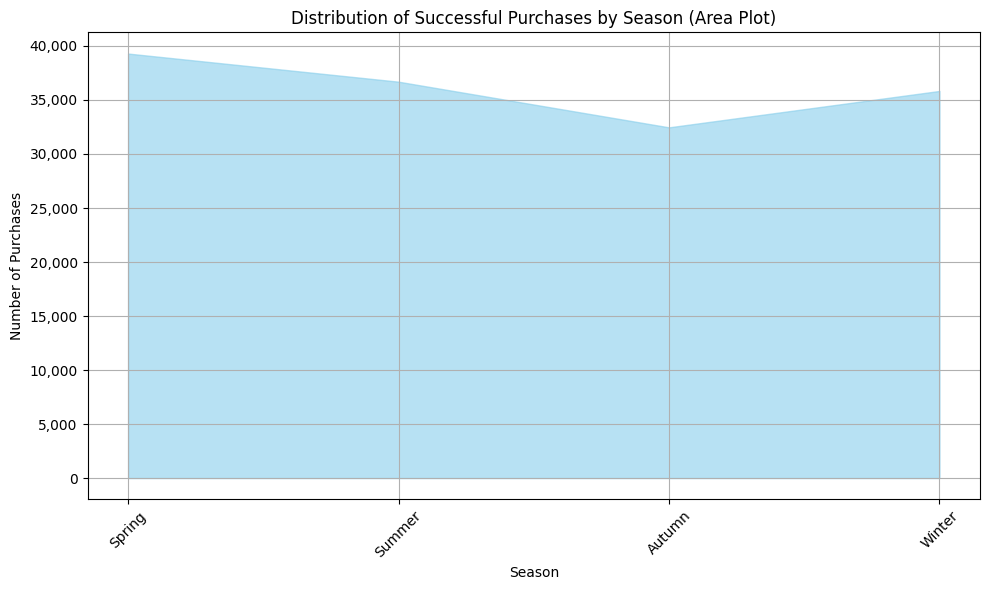

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, dayofweek
from matplotlib.ticker import FuncFormatter

# Get sample data from feature_df
sampled_purchase_df = feature_df.sample(withReplacement=False, fraction=0.2, seed=42)

# Filter sample based data based on succesful purchase
filtered_df = sampled_purchase_df.filter(sampled_purchase_df.made_purchase == 1)

# Group data based on season to see the distribution
distribution = filtered_df.groupBy("season").count().toPandas()

# Rename the columns
distribution = distribution.rename(columns={"season": "Season", "count": "Number of Purchases"})

# Format number
def format_int(x, pos):
    return f'{x:,.0f}'

# Create a FuncFormatter
y_format = FuncFormatter(format_int)

# Visualize the plot
plt.figure(figsize=(10, 6))
plt.fill_between(distribution["Season"], distribution["Number of Purchases"], color='skyblue', alpha=0.6)
plt.xlabel("Season")
plt.ylabel("Number of Purchases")
plt.title("Distribution of Successful Purchases by Season (Area Plot)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(y_format)
plt.grid(True)
plt.tight_layout()
plt.show()


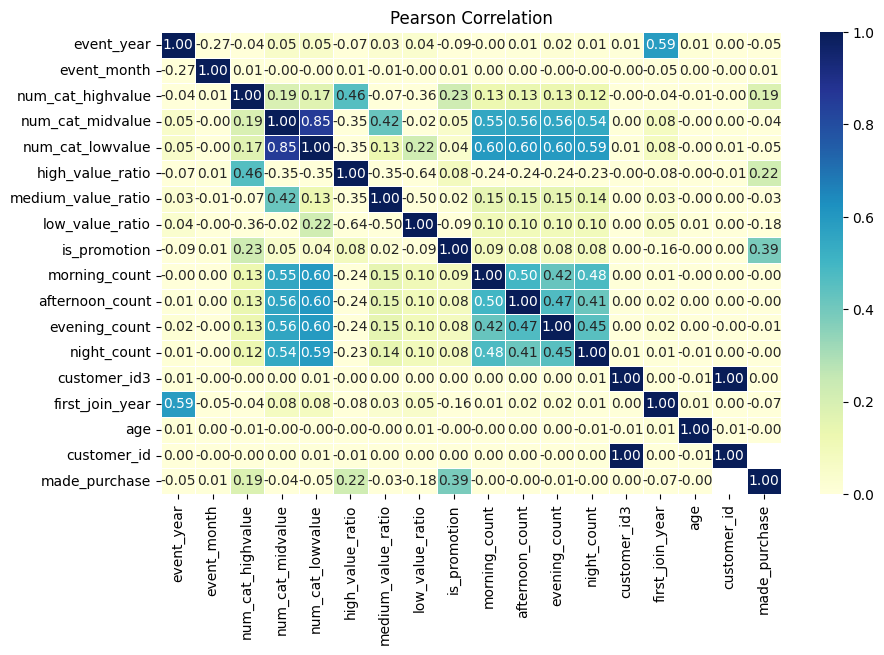

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 6))

# Convert dataframe to panda
feature_df_pandas = sampled_purchase_df.toPandas()

# Select numeric columns from the pandas dataframe
numeric_columns = feature_df_pandas.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_columns.corr(method="pearson")

# Create a heatmap of the correlation matrix
sns.heatmap(
    corr_matrix,
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.2f',
    cmap="YlGnBu",
    cbar=True,
    linewidths=0.5
)
plt.title("Pearson Correlation")
plt.show()

2.1.2 Write code to create/transform the columns based on your discussion above
- Hint: You can use one dataframe for both two use cases(classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case.


In [ ]:
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, year, coalesce

# I use reference year 2017, to make the data relevant with the earliest data
reference_year = 2017

# Use the reference year to calculate the duration_join_app
feature_df = feature_df.withColumn(
    "duration_join_app",
    reference_year - feature_df["first_join_year"]
)

feature_df = feature_df.withColumn(
    "is_java_island",
    when(
        (col("home_location").contains("Jakarta Raya")) |
        (col("home_location").contains("Jawa Barat")) |
        (col("home_location").contains("Jawa Tengah")) |
        (col("home_location").contains("Jawa Timur")) |
        (col("home_location").contains("Yogyakarta")) ,
        1
    ).otherwise(0)
)

feature_df = feature_df.withColumn(
    "duration_join_app",
    coalesce(col("duration_join_app"), lit(0))
)

# print the schema
feature_df.printSchema()


root
 |-- event_year: integer (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- season: string (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- first_join_year: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- payment_status: string 

In [ ]:
# drop unused column based on discussion
feature_df=feature_df.drop('session_id')\
                     .drop('customer_id')\
                     .drop('first_join_year')\
                     .drop('num_cat_highvalue')\
                     .drop('num_cat_midvalue')\
                     .drop('num_cat_lowvalue')\
                     .drop('season')
# print the schema
feature_df.printSchema()

root
 |-- event_year: integer (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- made_purchase: integer (nullable = false)
 |-- duration_join_app: integer (nullable = false)
 |-- is_java_island: integer (nullable = false)



In [ ]:
# Drop rows where any column has null values
feature_df = feature_df.dropna()

In [ ]:
feature_df.printSchema()

root
 |-- event_year: integer (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- medium_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: integer (nullable = false)
 |-- morning_count: long (nullable = true)
 |-- afternoon_count: long (nullable = true)
 |-- evening_count: long (nullable = true)
 |-- night_count: long (nullable = true)
 |-- customer_id3: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- session_id3: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- made_purchase: integer (nullable = false)
 |-- duration_join_app: integer (nullable = false)
 |-- is_java_island: integer (nullable = false)



### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet**

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

# Define categorical and numeric columns
categoryInputCols = ['is_promotion', 'gender', 'is_java_island']
numericInputCols = ['high_value_ratio', 'medium_value_ratio', 'low_value_ratio', 'duration_join_app', 'age','morning_count','afternoon_count','night_count','evening_count']
categoryOutputCol = 'made_purchase'

# String Indexer process for categorical columns and the label
inputIndexer = StringIndexer(
    inputCols=categoryInputCols + [categoryOutputCol],
    outputCols=[f"{x}_index" for x in categoryInputCols] + ['label']
)

# One Hot Encoder process for categorical columns
inputCols_OHE = [f"{x}_index" for x in categoryInputCols]
outputCols_OHE = [f"{x}_vec" for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

# Scale numeric columns
scaled_numeric_cols = []
scalers = []
for col in numericInputCols:
    assembler = VectorAssembler(inputCols=[col], outputCol=f"{col}_vector")
    scaler = StandardScaler(inputCol=f"{col}_vector", outputCol=f"{col}_scaled", withMean=True, withStd=True)
    scaled_numeric_cols.append(f"{col}_scaled")
    scalers.extend([assembler, scaler])

# Assemble final feature vector
assemblerInputs = outputCols_OHE + scaled_numeric_cols
featureAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Define classifiers
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)


**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet**

In [ ]:
rf_pipeline = Pipeline(stages=[inputIndexer, encoder] + scalers + [featureAssembler, rf])
gbt_pipeline = Pipeline(stages=[inputIndexer, encoder] + scalers + [featureAssembler, gbt])


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.  
Note: Due to the large size of the dataset, i use one year of data for training and another year for testing.

In [ ]:
# Filter based on event_year
train_data = feature_df.filter(feature_df.event_year == 2021)
test_data = feature_df.filter(feature_df.event_year == 2022)

# Count rows in train and test sets
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))


Training Dataset Count: 262476
Test Dataset Count: 193143


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [ ]:
# Fit and Transform for RF pipeline
rf_model = rf_pipeline.fit(train_data)
df_rf = rf_model.transform(test_data)

# Fit and Transform for GBT pipeline
gbt_model = gbt_pipeline.fit(train_data)
df_gbt = gbt_model.transform(test_data)

# Display the result
df_rf.select('features','label','prediction','probability').show()
df_gbt.select('features','label','prediction','probability').show()



+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|[1.0,1.0,1.0,-0.3...|  0.0|       0.0|[0.60495546301171...|
|[1.0,1.0,1.0,-1.1...|  0.0|       0.0|[0.67372520019270...|
|[0.0,1.0,1.0,-0.8...|  0.0|       0.0|[0.82705134567381...|
|[1.0,1.0,0.0,-1.1...|  0.0|       0.0|[0.61162707896350...|
|[0.0,1.0,0.0,-0.8...|  0.0|       0.0|[0.81074783827067...|
|[1.0,0.0,1.0,-1.0...|  1.0|       1.0|[0.17955629551453...|
|[1.0,0.0,0.0,1.32...|  0.0|       0.0|[0.84268416938320...|
|[1.0,1.0,0.0,0.38...|  0.0|       0.0|[0.64706174331424...|
|[1.0,1.0,1.0,-0.5...|  0.0|       0.0|[0.61162707896350...|
|[1.0,0.0,0.0,-1.3...|  1.0|       1.0|[0.01227021971914...|
|[0.0,1.0,1.0,1.32...|  0.0|       0.0|[0.85878488773371...|
|[1.0,1.0,1.0,-0.3...|  1.0|       0.0|[0.62719793800758...|
|[0.0,0.0,0.0,1.32...|  0.0|       0.0|[0.85847987621319...|
|[1.0,0.0,1.0,0.38...|  

In [ ]:
feature_df.write.csv('/content/drive/MyDrive/filename.csv', header=True)


2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
- Draw a ROC plot.
- Discuss which one is the better model(no word limit, please keep it concise)

In [ ]:
def compute_metrics(predictions):
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()

    # calculate accuracy, precision, recall and f1
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2/((1/recall)+(1/precision))

    # display the result
    print("TN : ",TN)
    print("TP : ",TP)
    print("FN : ",FN)
    print("Fp : ",FP)
    print("Accuracy : ",accuracy)
    print("Precision : ",precision)
    print("Recall :",recall)
    print("F1 : ",f1)


print('GBT:')
compute_metrics(df_gbt)
print('Random Forest:')
compute_metrics(df_rf)

GBT:
TN :  112265
TP :  40994
FN :  39760
Fp :  124
Accuracy :  0.7935001527365734
Precision :  0.9969842891191206
Recall : 0.5076404883968596
F1 :  0.6727386110017067
Random Forest:
TN :  112234
TP :  41014
FN :  39740
Fp :  155
Accuracy :  0.7934432001159762
Precision :  0.9962350312128058
Recall : 0.507888154147163
F1 :  0.672785282514374


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# calculate ROC Value for Random Forest
auc_rf = rf_evaluator.evaluate(df_rf)
print(auc_rf)

0.8534034168062464


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# calculate ROC Value for GBT
auc_gbt = gbt_evaluator.evaluate(df_gbt)
print(auc_gbt)

0.8591452426498771


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


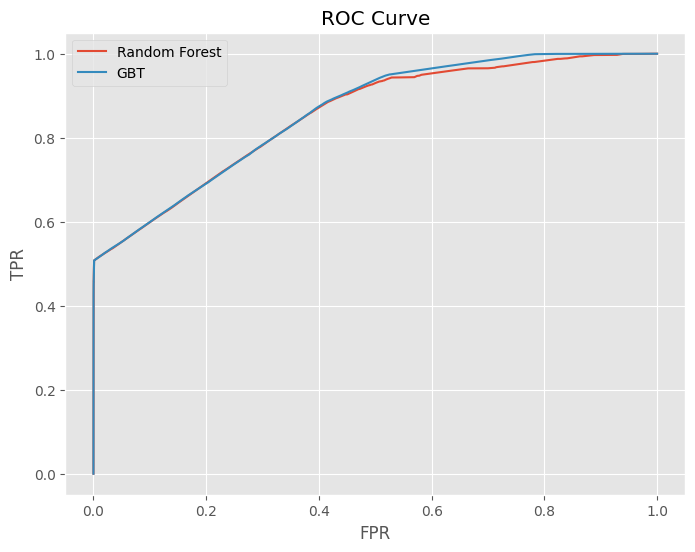

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
# Class to draw ROC Plot for
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points
    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
def plot_roc_curve(ax, x, y, label):
    ax.plot(x, y, label=label)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6))

# For Random Forest
preds_rf = df_rf.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points_rf = CurveMetrics(preds_rf).get_curve('roc')
x_val_rf = [x[0] for x in points_rf]
y_val_rf = [x[1] for x in points_rf]

# For GBT
preds_gbt = df_gbt.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points_gbt = CurveMetrics(preds_gbt).get_curve('roc')
x_val_gbt = [x[0] for x in points_gbt]
y_val_gbt = [x[1] for x in points_gbt]

# Plot ROC curves
plot_roc_curve(ax, x_val_rf, y_val_rf, label='Random Forest')
plot_roc_curve(ax, x_val_gbt, y_val_gbt, label='GBT')

# Display the plot
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Conclusion**

Accuracy:

Both GBT and Random Forest have a similar accuracy of around 80%. So ,both models are good at distinguishing whether or not people will make a purchase.

Precision :

GBT has a slightly higher precision than Random Forest.
So, GBT is better at distinguishing that someone actually will make a purchase (less likely to produce false positives).

Recall:

Random Forest has a slightly higher recall than GBT.
So ,Random Forest is better at identifying all of the people that will make a purchase ( less likely to produce false negative)

F1 Score:

Random Forest and GBT have a similar F1 Score of around 66%. So, they are okay for overall performance classifiers.

ROC :

GBT has a higher ROC value than Random Forest.
So, GBT is better at identifying whether or not people will make a purchase.


**As conclusion, GBT performs better than Random Forest in this case.** GBT models may require longer training times and exhibit  sensitivity to outliers. However, the choice between the two models  depends on the data and case.



2.4.3 Save the better model, we will need this for Part B of assignment 2.  
(note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [ ]:
# Save the better model
gbt_model.save('ecommerce_model')

### Part 3: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

**Addressing Security Concerns Associated with Big Data in Indonesia**

Big data technology helps individuals to work with big and diverse datasets with high speeds. Additionally, it helps organization to make decisions and understand customer behaviour. However, when dealing with complex data, security becomes a concern. Big data privacy and security are crucial because they are a matter of trust. When people share their data, they may provide sensitive information. When organization prioritize data security , they win customer loyalty by respecting individual privacy and build their brand reputation.

**There are some possible threats when we deal with Big Data:**

**1. Breach of Data**
This occurs when unauthorized individuals access the data. It can result from many vulnerabilities such as outdated software, weak passwords, app security weaknesses, and malware. Data breaches can lead to a loss of consumer trust and financial losses due to privacy violations. For example, in Indonesia, a data breach occurred in the banking system (BRI Life), where hackers sold two million customer records, including electronic ID card information, birth certificates, and health records, potentially leading to identity theft and fraudulent activities.

**2. Irrelevant Data**
Organizations may collect extensive data without a clear purpose, assuming that gathering large amounts of data will prove valuable in the future. For instance, Indonesia's government introduced the Peduli Lindungi surveillance program during the pandemic, which requested permissions for location, gallery access, phone files, and camera access. This extensive data collection can raise concerns, especially Indonesia has no comprehensive legal framework for personal data protection .

**3. Data Discrimination**

Organizations can gain access to sensitive information and use algorithms that unfairly exclude certain individuals based on factors like age or ethnicity. These biased algorithms introduce unfairness and discrimination into analytics and decision-making processes.

**4. Data Management**
It happens when companies fail to provide highly secure facilities to ensure data security. Poor decisions may lead to inadequate measures to protect data. Notably, Indonesia lacks a comprehensive legal framework regarding personal data protection.


**To mitigate these threats, organizations can take several preventive measures:**

**Encrypting Data**

Organization could employ encryption tools to secure data from various sources, ensuring the protection of confidential information.

**Controlling User Access**

Organization could build a policy-based approach to comprehensive protection rather than minimizing access control.

**Detecting and Preventing Attacks**

Organization could establish an Intrusion Prevention system by monitoring network traffic and user activities to identify and isolate infiltrations before they cause harm.

**Ensuring Physical Data Protection**
Organization could use video surveillance and other physical security measures to address physical threats.

Additionally, it is essential for the government to consider enacting data protection laws to safeguard against data misuse and threats, providing a legal framework for data security and privacy .




## References:
Bhwana, P. G. (2023, August 22). Indonesia Aims to Censor Over-the-top Platform Contents. Tempo. https://en.tempo.co/read/1762702/indonesia-aims-to-censor-over-the-top-platform-contents?tracking_page_direct

Cipher. (2018, January 6). The 5 Biggest Challenges in Global Data Privacy and Protection. Cipher. https://cipher.com/blog/the-5-biggest-challenges-in-global-data-privacy-and-protection/

cyberinsiders. (2020, April 20). What Are the Biggest Privacy Issues Associated with Big Data? Cybersecurity Insiders. https://www.cybersecurity-insiders.com/what-are-the-biggest-privacy-issues-associated-with-big-data/

Fanny, R. D. G., & Danti, A. R. A. (2021, November 23). Privacy on Personal Data Collection: Surveillance During the New Normal in Indonesia. Www.atlantis-Press.com; Atlantis Press. https://doi.org/10.2991/assehr.k.211112.074‌

Jain, P., Gyanchandani, M., & Khare, N. (2016). Big data privacy: a technological perspective and review. Journal of Big Data, 3(1). https://doi.org/10.1186/s40537-016-0059-y

Sanie, M. (2022, April 8). Big Data Security: Biggest Challenges and Best Practices. Cprime. https://www.cprime.com/resources/blog/big-data-security-biggest-challenges-and-best-practices/

‌10 Best Practices for Securing Big Data. (2016, September 7). PCMag Australia. https://au.pcmag.com/feature/43372/10-best-practices-for-securing-big-data

‌